<a href="https://colab.research.google.com/github/nilesh2gupta/BankingSystem/blob/main/Combining_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spacy networkx
!pip install spacy spacy-entity-linker wikipedia-api
!pip install mwparserfromhell
!pip install wptools
!pip install torch_geometric

  Preparing metadata (setup.py) ... done
  Created wheel for spacy-entity-linker: filename=spacy_entity_linker-1.0.3-py3-none-any.whl size=14375 sha256=83d8ef3575e74a5d341a95085082adc03816fbf925914589b901285d7f1f4023
  Stored in directory: /root/.cache/pip/wheels/6d/73/f9/568b5f541ed2d6f9adb8556b8ef9995e5528f3f9ab2b83b196
Successfully built spacy-entity-linker
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 49.7 MB/s eta 0:00:00
  Created wheel for html2text: filename=html2text-2024.2.26-py3-none-any.whl size=33111 sha256=4079706fec6cd4f9a2cd4fc0454b7998b23f4bcf6bbd99c81220ee760848ea89
  Stored in directory: /root/.cache/pip/wheels/f3/96/6d/a7eba8f80d31cbd188a2787b81514d82fc5ae6943c44777659
Successfully built html2text
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.

In [46]:
import spacy
import requests
import wptools
import networkx as nx
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaModel
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
import wikipediaapi
import re

# Loading Spacy model
nlp = spacy.load("en_core_web_sm")

# Loading RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

class KnowledgeGraphBuilder:
    def __init__(self, news_text):
        self.news_text = news_text
        self.coarse_graph = None
        self.fine_graph = None
        self.node_to_idx_coarse = {}
        self.node_to_idx_fine = {}

    def get_wikipedia_url(self, entity):
        url = f"https://en.wikipedia.org/wiki/{entity.replace(' ', '_')}"
        return url

    def fetch_wikipedia_summary(self, topic):
        wiki = wikipediaapi.Wikipedia('MyWikiFetcher/1.0 (nilegupta2001@gmail.com)')
        page = wiki.page(topic)
        if page.exists():
            return page.summary
        return None

    def augment_news_with_entities(self, news_text, entity_summaries):
        augmented_text = news_text
        for entity, summary in entity_summaries.items():
            if summary:
                augmented_text += f"\n{entity}: {summary}"
        return augmented_text

    def get_infobox(self, title, limit=20):
        try:
            page = wptools.page(title)
            page.get_parse()
            infobox = page.data.get('infobox')
            if infobox:
                values = list(infobox.values())[:limit]  # Get only the first `limit` values
                cleaned_values = [re.sub(r'\W+', ' ', str(value)).strip() for value in values]
                return cleaned_values
            return None
        except Exception as e:
            print(f"An error occurred: {e}")
            return None
    def get_roberta_embeddings(self, text):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    def build_coarse_graph(self):
        doc = nlp(self.news_text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        coarse_grained_summaries = {entity: self.fetch_wikipedia_summary(entity) for entity, label in entities}
        augmented_news_coarse = self.augment_news_with_entities(self.news_text, coarse_grained_summaries)
        doc_coarse = nlp(augmented_news_coarse)
        entities_coarse = [(ent.text, ent.label_) for ent in doc_coarse.ents]
        linked_entities_coarse = {entity: self.get_wikipedia_url(entity) for entity, label in entities_coarse}

        G_coarse = nx.Graph()

        for entity, url in linked_entities_coarse.items():
            embedding = self.get_roberta_embeddings(entity)
            G_coarse.add_node(entity, url=url, embedding=embedding)

        for sent in doc_coarse.sents:
            sent_entities = [ent.text for ent in sent.ents]
            for i, entity1 in enumerate(sent_entities):
                for entity2 in sent_entities[i+1:]:
                    if G_coarse.has_node(entity1) and G_coarse.has_node(entity2):
                        G_coarse.add_edge(entity1, entity2)

        self.coarse_graph = G_coarse

    def build_fine_graph(self):
        doc = nlp(self.news_text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        fine_grained_infoboxes = {entity: self.get_infobox(entity) for entity, label in entities}
        augmented_news_fine = self.augment_news_with_entities(self.news_text, fine_grained_infoboxes)
        pattern = r'[\|\[\]]'
        augmented_news_fine = re.sub(pattern, '', augmented_news_fine)
        doc_fine = nlp(augmented_news_fine)
        entities_fine = [(ent.text, ent.label_) for ent in doc_fine.ents]
        linked_entities_fine = {entity: self.get_wikipedia_url(entity) for entity, label in entities_fine}

        G_fine = nx.Graph()

        for entity, url in linked_entities_fine.items():
            embedding = self.get_roberta_embeddings(entity)
            G_fine.add_node(entity, url=url, embedding=embedding)

        for sent in doc_fine.sents:
            sent_entities = [ent.text for ent in sent.ents]
            for i, entity1 in enumerate(sent_entities):
                for entity2 in sent_entities[i+1:]:
                    if G_fine.has_node(entity1) and G_fine.has_node(entity2):
                        G_fine.add_edge(entity1, entity2)

        self.fine_graph = G_fine

    def convert_to_pytorch_geometric(self):
        self.node_to_idx_coarse = {node: idx for idx, node in enumerate(self.coarse_graph.nodes())}
        edge_list_coarse = nx.to_edgelist(self.coarse_graph)
        edge_index_coarse = torch.tensor([[self.node_to_idx_coarse[u], self.node_to_idx_coarse[v]] for u, v, _ in edge_list_coarse], dtype=torch.long).t().contiguous()
        node_features_coarse = np.array([node[1]['embedding'] for node in self.coarse_graph.nodes(data=True)])
        node_features_coarse = torch.tensor(node_features_coarse, dtype=torch.float)

        self.node_to_idx_fine = {node: idx for idx, node in enumerate(self.fine_graph.nodes())}
        edge_list_fine = nx.to_edgelist(self.fine_graph)
        edge_index_fine = torch.tensor([[self.node_to_idx_fine[u], self.node_to_idx_fine[v]] for u, v, _ in edge_list_fine], dtype=torch.long).t().contiguous()
        node_features_fine = np.array([node[1]['embedding'] for node in self.fine_graph.nodes(data=True)])
        node_features_fine = torch.tensor(node_features_fine, dtype=torch.float)

        data_coarse = Data(x=node_features_coarse, edge_index=edge_index_coarse)
        data_fine = Data(x=node_features_fine, edge_index=edge_index_fine)

        return data_coarse, data_fine

class GATModel(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=num_heads, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * num_heads, out_dim, heads=1, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train_gat_model(model, data, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.x)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')
    return model

def get_contextual_representations(news_text):
    kg_builder = KnowledgeGraphBuilder(news_text)
    kg_builder.build_coarse_graph()
    kg_builder.build_fine_graph()
    data_coarse, data_fine = kg_builder.convert_to_pytorch_geometric()

    in_dim = data_coarse.x.shape[1]
    hidden_dim = 96
    out_dim = 768
    num_heads = 8

    model = GATModel(in_dim, hidden_dim, out_dim, num_heads)

    # Train the model (you may need to adjust the number of epochs and learning rate)
    model = train_gat_model(model, data_coarse, epochs=100, lr=0.001)
    model = train_gat_model(model, data_fine, epochs=100, lr=0.001)

    # Get the contextual representations
    model.eval()
    with torch.no_grad():
        contextual_vectors_coarse = model(data_coarse)
        contextual_vectors_fine = model(data_fine)

    return contextual_vectors_coarse, contextual_vectors_fine


# Plot the graphs side by side
def plot_graphs(kg_builder):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Coarse-grained graph
    pos_coarse = nx.circular_layout(kg_builder.coarse_graph)
    nx.draw(kg_builder.coarse_graph, pos_coarse, with_labels=True, node_size=500, node_color="lightblue", font_size=10, ax=ax1)
    ax1.set_title("Coarse-Grained Knowledge Graph")

    # Fine-grained graph
    pos_fine = nx.circular_layout(kg_builder.fine_graph)
    nx.draw(kg_builder.fine_graph, pos_fine, with_labels=True, node_size=500, node_color="lightgreen", font_size=10, ax=ax2)
    ax2.set_title("Fine-Grained Knowledge Graph")

    plt.show()



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


en.wikipedia.org (parse) Microsoft
en.wikipedia.org (imageinfo) File:Aerial Microsoft West Campus Au...
Microsoft (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Aerial Mi...
  infobox: <dict(38)> name, logo, logo_size, logo_alt, image, imag...
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:M...
  pageid: 19001
  parsetree: <str(242992)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Microsoft
  wikibase: Q2283
  wikidata_url: https://www.wikidata.org/wiki/Q2283
  wikitext: <str(207133)> {{Short description|American multination...
}


Epoch 10/100, Loss: 0.40185824036598206
Epoch 20/100, Loss: 0.49576520919799805
Epoch 30/100, Loss: 0.5661799311637878
Epoch 40/100, Loss: 0.8768946528434753
Epoch 50/100, Loss: 0.571038007736206
Epoch 60/100, Loss: 0.24210003018379211
Epoch 70/100, Loss: 0.30835968255996704
Epoch 80/100, Loss: 0.250937283039093
Epoch 90/100, Loss: 0.29422274231910706
Epoch 100/100, Loss: 0.2730861008167267
Epoch 10/100, Loss: 0.07284051179885864
Epoch 20/100, Loss: 0.09170294553041458
Epoch 30/100, Loss: 0.0761190727353096
Epoch 40/100, Loss: 0.09183309227228165
Epoch 50/100, Loss: 0.11320994794368744
Epoch 60/100, Loss: 0.08554492145776749
Epoch 70/100, Loss: 0.07477479428052902
Epoch 80/100, Loss: 0.1050601378083229
Epoch 90/100, Loss: 0.09170565754175186
Epoch 100/100, Loss: 0.12842528522014618
Contextual Vectors shape (Coarse): torch.Size([71, 768])
Contextual Vectors (Coarse): tensor([[ 0.3211,  0.0596,  0.3292,  ..., -0.1893, -0.1754,  0.1513],
        [ 0.3280,  0.0504,  0.3329,  ..., -0.2091, 

en.wikipedia.org (parse) Microsoft
en.wikipedia.org (imageinfo) File:Aerial Microsoft West Campus Au...
Microsoft (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Aerial Mi...
  infobox: <dict(38)> name, logo, logo_size, logo_alt, image, imag...
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:M...
  pageid: 19001
  parsetree: <str(242992)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Microsoft
  wikibase: Q2283
  wikidata_url: https://www.wikidata.org/wiki/Q2283
  wikitext: <str(207133)> {{Short description|American multination...
}


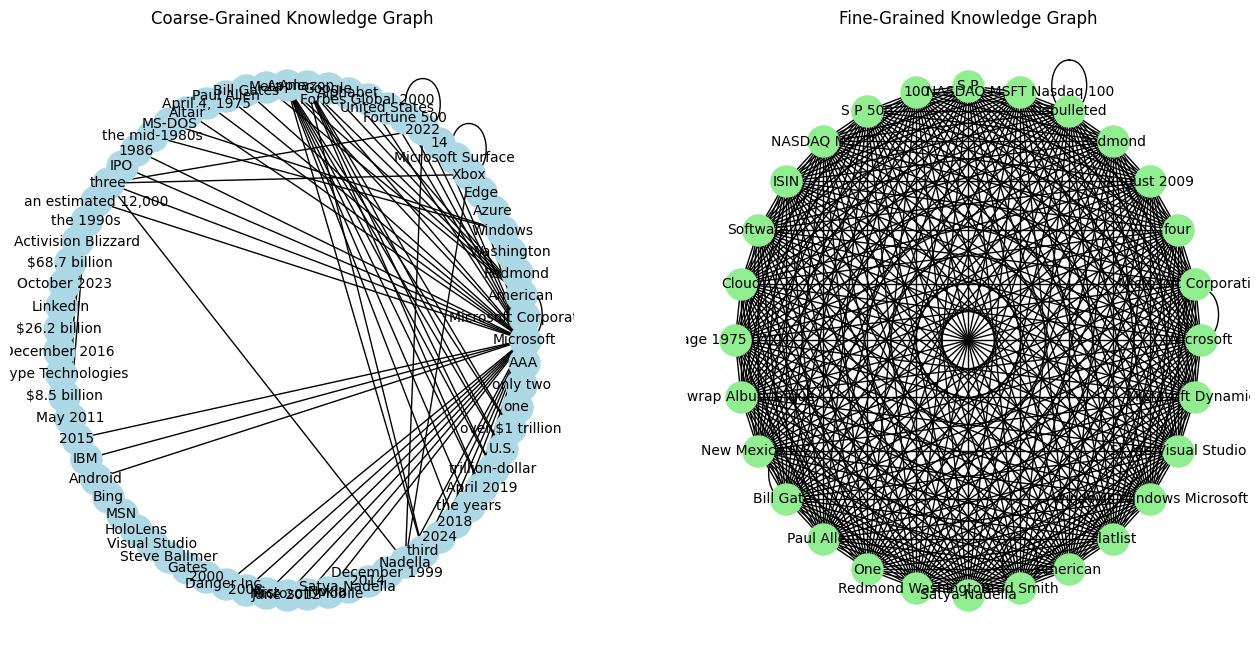

In [47]:
# Example usage
news_text = "Microsoft is the largest software company"
contextual_vectors_coarse, contextual_vectors_fine = get_contextual_representations(news_text)
print("Contextual Vectors shape (Coarse):", contextual_vectors_coarse.shape)
print("Contextual Vectors (Coarse):", contextual_vectors_coarse)
print("Contextual Vectors shape (Fine):", contextual_vectors_fine.shape)
print("Contextual Vectors (Fine):", contextual_vectors_fine)

kg_builder = KnowledgeGraphBuilder(news_text)
kg_builder.build_coarse_graph()
kg_builder.build_fine_graph()

# Plot the graphs
plot_graphs(kg_builder)

In [71]:
import tensorflow as tf
from transformers import TFRobertaModel, RobertaTokenizer
import numpy as np

class AdapterLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, adapter_dim):
        super(AdapterLayer, self).__init__()
        self.linear1 = tf.keras.layers.Dense(adapter_dim, activation='relu')
        self.linear2 = tf.keras.layers.Dense(input_dim)

    def call(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

class RobertaWithAdapter(tf.keras.Model):
    def __init__(self, model_name, adapter_dim):
        super(RobertaWithAdapter, self).__init__()
        self.roberta = TFRobertaModel.from_pretrained(model_name)
        self.adapter = AdapterLayer(self.roberta.config.hidden_size, adapter_dim)

    def call(self, inputs):
        input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state

        # Pass through adapter layer
        adapter_output = self.adapter(sequence_output)

        return adapter_output

# Initialize tokenizer and model
model_name = "roberta-base"
adapter_dim = 64  # Size of the adapter layer
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaWithAdapter(model_name, adapter_dim)

# Example input text
text = "Microsoft is the largest software company"
inputs = tokenizer(text, return_tensors="tf")

# Forward pass through the model
adapter_output = model(inputs)
adapter_output = adapter_output.numpy()

print("Adapter Output Shape:", adapter_output[0].shape)
print("Adapter Output:", adapter_output[0])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Adapter Output Shape: (8, 768)
Adapter Output: [[-0.32004336  0.05758854  0.0018318  ... -0.17280357 -0.27142215
   0.14624277]
 [-0.22980559  0.23881824 -0.00362461 ...  0.09429146 -0.24241404
   0.13013534]
 [-0.3715964   0.11038555  0.11480003 ... -0.00887927 -0.17425662
   0.07736415]
 ...
 [-0.22250572  0.33463207 -0.00517405 ...  0.20547332 -0.2391888
  -0.02528129]
 [-0.30358645  0.17498879  0.0304361  ... -0.04398162 -0.2400712
  -0.00478867]
 [-0.352641    0.06177532 -0.01084594 ... -0.17887071 -0.28727147
   0.14974263]]


In [72]:
import tensorflow as tf
import numpy as np

class AttentiveGraphPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):
        super(AttentiveGraphPoolingLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.WQ = tf.keras.layers.Dense(hidden_dim)
        self.WK = tf.keras.layers.Dense(hidden_dim)
        self.WV = tf.keras.layers.Dense(hidden_dim)

    def call(self, h, c):
        Q = tf.expand_dims(self.WQ(h), axis=1)
        K = tf.expand_dims(self.WK(c), axis=0)
        V = tf.expand_dims(self.WV(c), axis=0)

        attn_scores = tf.matmul(Q, K, transpose_b=True)
        attn_scores = attn_scores / tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32))

        attn_weights = tf.nn.softmax(attn_scores, axis=-1)

        attended_values = tf.matmul(attn_weights, V)
        attended_values = tf.squeeze(attended_values, axis=1)

        return attended_values, tf.squeeze(attn_weights, axis=1)


In [73]:
h = adapter_output[0]
c = contextual_vectors_fine.numpy()
hidden_dim=768
attentive_pooling_layer = AttentiveGraphPoolingLayer(hidden_dim)
attended_values, attn_weights = attentive_pooling_layer(h, c)
attentive_pooling_layer_output =attended_values.numpy()
print("Attended Values:", attentive_pooling_layer_output.shape)
print("Attended Values:", attentive_pooling_layer_output)



Attended Values: (8, 768)
Attended Values: [[ 0.19771191  0.45140272  0.04061633 ... -0.6488801   0.1176636
   0.54635626]
 [ 0.19769403  0.45148554  0.04066262 ... -0.6488701   0.1176985
   0.54635066]
 [ 0.19765802  0.45166323  0.04076433 ... -0.648847    0.11777461
   0.546339  ]
 ...
 [ 0.19766128  0.45163596  0.04074666 ... -0.64885086  0.11776532
   0.54633915]
 [ 0.19766347  0.45162705  0.04074206 ... -0.64885175  0.11776148
   0.54633987]
 [ 0.19771041  0.45141247  0.04062217 ... -0.6488787   0.1176676
   0.5463558 ]]


In [74]:
textual_vector = adapter_output[0]
AGPL_output = attentive_pooling_layer_output
coarse_grained_output = contextual_vectors_coarse.numpy()


In [75]:
print("shape of textual_vector: ", textual_vector.shape)
print("shape of AGPL_output: ", AGPL_output.shape)
print("shape of coarse_grained_output: ", coarse_grained_output.shape)

shape of textual_vector:  (8, 768)
shape of AGPL_output:  (8, 768)
shape of coarse_grained_output:  (71, 768)


In [77]:
final_context_vector = np.concatenate((textual_vector, AGPL_output, coarse_grained_output))
print("shape of result: ", final_context_vector.shape)
print("result: ", final_context_vector)

shape of result:  (87, 768)
result:  [[-0.32004336  0.05758854  0.0018318  ... -0.17280357 -0.27142215
   0.14624277]
 [-0.22980559  0.23881824 -0.00362461 ...  0.09429146 -0.24241404
   0.13013534]
 [-0.3715964   0.11038555  0.11480003 ... -0.00887927 -0.17425662
   0.07736415]
 ...
 [ 0.252944    0.08481855  0.27536857 ... -0.20781821 -0.18058634
   0.09878562]
 [ 0.21999437  0.08789983  0.25016132 ... -0.21571545 -0.18089046
   0.07927449]
 [ 0.20299807  0.08997542  0.23647137 ... -0.21559194 -0.18091366
   0.06575574]]


In [89]:
x_train = final_context_vector.reshape(1, 87,768)
y_train = np.array([[1]])

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 claims_input (InputLayer)   [(None, 87, 768)]            0         []                            
                                                                                                  
 Conv1D_layer (Conv1D)       (None, 83, 256)              983296    ['claims_input[0][0]']        
                                                                                                  
 MaxPooling_layer (MaxPooli  (None, 41, 256)              0         ['Conv1D_layer[0][0]']        
 ng1D)                                                                                            
                                                                                                  
 bidirectional_9 (Bidirecti  (None, 41, 200)              285600    ['MaxPooling_layer[0][0]

1/1 [==============================] - 10s 10s/step - loss: 0.7166 - accuracy: 1.0000
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 0.5533 - accuracy: 1.0000

1/1 [==============================] - 0s 173ms/step - loss: 0.5533 - accuracy: 1.0000
Epoch 3/30
1/1 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 1.0000

1/1 [==============================] - 0s 210ms/step - loss: 0.1244 - accuracy: 1.0000
Epoch 4/30
1/1 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 1.0000

1/1 [==============================] - 0s 171ms/step - loss: 0.0107 - accuracy: 1.0000
Epoch 5/30
1/1 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

1/1 [==============================] - 0s 159ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 6/30
1/1 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000

1/1 [==============================] - 0s 147ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 7/30
1/1 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 1.0000

1/1 [==============================] - 0s 162ms/step - loss: 0.0080 - accuracy: 1.0000
Epoch 8/30
1/1 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000

1/1 [==============================] - 0s 177ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 9/30
1/1 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 1.0000

1/1 [==============================] - 0s 146ms/step - loss: 0.4567 - accuracy: 1.0000
Epoch 10/30
1/1 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 1.0000

1/1 [==============================] - 0s 70ms/step - loss: 0.0300 - accuracy: 1.0000
Epoch 11/30
1/1 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

1/1 [==============================] - 0s 69ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 12/30
1/1 [==============================] - ETA: 0s - loss: 8.1089e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 8.1089e-04 - accuracy: 1.0000
Epoch 13/30
1/1 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000

1/1 [==============================] - 0s 71ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 14/30
1/1 [==============================] - ETA: 0s - loss: 3.7425e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 3.7425e-04 - accuracy: 1.0000
Epoch 15/30
1/1 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 1.0000

1/1 [==============================] - 0s 70ms/step - loss: 0.0231 - accuracy: 1.0000
Epoch 16/30
1/1 [==============================] - ETA: 0s - loss: 1.0490e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 69ms/step - loss: 1.0490e-05 - accuracy: 1.0000
Epoch 17/30
1/1 [==============================] - ETA: 0s - loss: 7.7861e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 92ms/step - loss: 7.7861e-04 - accuracy: 1.0000
Epoch 18/30
1/1 [==============================] - ETA: 0s - loss: 5.2689e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 101ms/step - loss: 5.2689e-05 - accuracy: 1.0000
Epoch 19/30
1/1 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

1/1 [==============================] - 0s 80ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 20/30
1/1 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

1/1 [==============================] - 0s 80ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 21/30
1/1 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 0.0615 - accuracy: 1.0000
Epoch 22/30
1/1 [==============================] - ETA: 0s - loss: 1.8857e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 72ms/step - loss: 1.8857e-04 - accuracy: 1.0000
Epoch 23/30
1/1 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 1.0000

1/1 [==============================] - 0s 71ms/step - loss: 0.0110 - accuracy: 1.0000
Epoch 24/30
1/1 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 1.0000

1/1 [==============================] - 0s 82ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 25/30
1/1 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 26/30
1/1 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

1/1 [==============================] - 0s 72ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 27/30
1/1 [==============================] - ETA: 0s - loss: 1.7524e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 71ms/step - loss: 1.7524e-05 - accuracy: 1.0000
Epoch 28/30
1/1 [==============================] - ETA: 0s - loss: 8.3446e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 8.3446e-06 - accuracy: 1.0000
Epoch 29/30
1/1 [==============================] - ETA: 0s - loss: 4.8279e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 104ms/step - loss: 4.8279e-05 - accuracy: 1.0000
Epoch 30/30
1/1 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 1.0000

1/1 [==============================] - 0s 101ms/step - loss: 0.0064 - accuracy: 1.0000


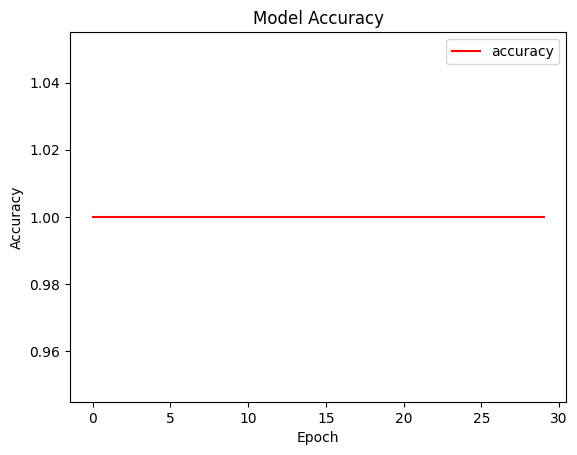

In [92]:
from keras.layers import Input,Flatten, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D, Attention
from keras.models import Model
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

max_squence_length = 87
embedding_dim = 768

# final textual vector output is feeded as input
input_layer = Input(shape=(max_squence_length,embedding_dim,), name='claims_input')

# Convolutional layer
conv_layer = Conv1D(filters=256, kernel_size=5, activation='relu', name='Conv1D_layer')(input_layer)
pooling_layer = MaxPooling1D(pool_size=2, name='MaxPooling_layer')(conv_layer)

# Bidirectional LSTM layer
bilstm_layer = Bidirectional(LSTM(100, return_sequences=True, name='BiLSTM_layer'))(pooling_layer)

# Attention mechanism
attention = Attention(name='Attention_layer')([bilstm_layer, bilstm_layer])
attention_pooling = GlobalMaxPooling1D(name='Attention_Pooling_layer')(attention)

# Dense layers
dense_layer = Dense(100, activation='relu', name='Dense_layer_1')(attention_pooling)
dropout_layer = Dropout(0.6, name='Dropout_layer_1')(dense_layer)
dense_layer_2 = Dense(50, activation='relu', name='Dense_layer_2')(dropout_layer)
dropout_layer_2 = Dropout(0.5, name='Dropout_layer_2')(dense_layer_2)

# Output layer for multi-class classification
output_layer = Dense(3, activation='softmax', name='output_layer')(dropout_layer_2)


#the model
model = Model(inputs=input_layer, outputs=output_layer)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=Nadam(learning_rate=0.001), loss=loss, metrics=['accuracy'])

#model summary
model.summary()

checkpoint_callback = ModelCheckpoint('combined_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


#training parameters
batch_size = 1
epochs = 30

history = model.fit(
    x_train,
    y_train,
    batch_size=1,
    epochs=epochs,
    validation_split=0.0,
    callbacks=[checkpoint_callback]
)

#graph
plt.plot(history.history['accuracy'], color='red',label='accuracy')
#plt.plot(history.history['val_accuracy'],color='blue',label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
